In [1]:
import pandas as pd
import requests
import os
from datetime import datetime
from data_creation import download_ecallisto_files, LOCAL_DATA_FOLDER
from glob import glob
from radiospectra.sources import CallistoSpectrogram
from spectogram_utils import spec_to_pd_dataframe, plot_spectogram

In [2]:
paths = download_ecallisto_files(instrument='ALASKA', return_download_paths=False)

In [3]:
files = glob(os.path.join(LOCAL_DATA_FOLDER, '**', '*ALASKA-ANCHORAGE*.fit.gz'), recursive=True)

In [38]:
test = CallistoSpectrogram.read(files[1])

In [43]:
import numpy as np
import numpy.ma as ma
def masked_spectogram_to_array(spectogram):
    """
    Converts a masked spectogram to an array
    """
    # Get row with no masked values
    idxs = np.where(~np.any(ma.getmaskarray(spectogram.data), axis=1))[0]
    # Keep only frequencies with no masked values
    spectogram.freq_axis = spectogram.freq_axis[idxs]
    # keep only rows in idxs
    data = ma.getdata(spectogram.data)
    spectogram.data = data[idxs, :]
    
    return spectogram

In [44]:
spec = masked_spectogram_to_array(test)

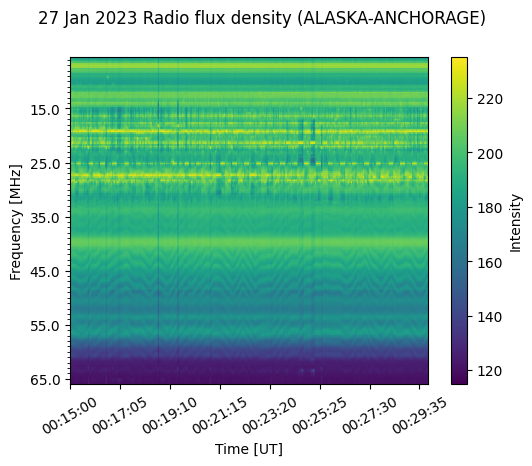

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [37]:
spec.peek()

In [8]:
freq_axises = []
for file in files:
    spec = CallistoSpectrogram.read(file)
    freq_axises.append(spec.freq_axis)

In [9]:
freq_before = freq_axises[0]
for freq in freq_axises[1:]:
    assert all([freq_before[i] == freq[i] for i in range(len(freq))])
    

In [10]:
test = masked_spectogram_to_array(test)

In [11]:
test_df_2 = spec_to_pd_dataframe(test)

In [47]:
import psycopg2

In [45]:
# Create variables for the connection to the OS
os.environ['PGHOST'] = 'localhost'
os.environ['PGUSER'] = 'postgres'
os.environ['PGPASSWORD'] = '1234'

##

CONNECTION = f' dbname=tsdb user={os.environ["PGUSER"]} host={os.environ["PGHOST"]} password={os.environ["PGPASSWORD"]}'

In [48]:
with psycopg2.connect(CONNECTION) as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT 'hello world'")
    print(cursor.fetchone())

('hello world',)


In [49]:
with psycopg2.connect(CONNECTION) as conn:
    cursor = conn.cursor()
    cursor.execute("""SELECT table_name
  FROM information_schema.tables
 WHERE table_schema='public'
   AND table_type='BASE TABLE';
    """)
    print(cursor.fetchall())

[('sensors',), ('sensors2',), ('_1',), ('sensors3',), ('alaska_anchorage_01',)]


In [ ]:
def create_table(table_name, columns):
    """
    Creates a table with the given name and columns
    """
    with psycopg2.connect(CONNECTION) as conn:
        cursor = conn.cursor()
        cursor.execute(f"""CREATE TABLE {table_name} (
                            id SERIAL PRIMARY KEY,
                            {columns}
                        );
                        """)
        conn.commit()
        cursor.close()

In [ ]:
def numbers_list_to_postgresql_columns(list_, type):
    """
    Converts a list to a string. Because postgresql does not allow
    numbers as column names, the numbers are encapsulated in "".
    """
    return ', '.join([f'"{item}" {type}' for item in list_])

In [ ]:
def create_instrument_table(instrument_name, frequencies, type='REAL'):
    """
    Creates a table for the given instrument with the given frequencies.
    """
    columns = numbers_list_to_postgresql_columns(frequencies, type=type)
    create_table(instrument_name, columns)
    

In [ ]:
create_instrument_table('alaska_anchorage_01', test.freq_axis)

In [ ]:
create_table('sensors3', test)

In [ ]:
def fetch_spe